In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from sklearn import metrics
import lime
import lime.lime_tabular
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [3]:
df = pd.read_csv("police-shootings/database.csv")

In [4]:
len(df)

2142

In [5]:
df.columns

Index(['id', 'name', 'date', 'manner_of_death', 'armed', 'age', 'gender',
       'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level',
       'flee', 'body_camera'],
      dtype='object')

In [6]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [4]:
# Feature Engineering + transformation
df = df[df["gender"].notnull()]
df = df[df["race"].notnull()]
df = df[df["armed"].notnull()]
df.drop("flee", axis=1, inplace=True)
df.drop("body_camera", axis=1, inplace=True)
race_map = {
     'A': 0,
     'W': 1, 
     'H': 0, 
     'B': 0, 
     'O': 0, 
     'N': 0   
}
df["race"] = df["race"].map(race_map)
df = pd.concat([df, pd.get_dummies(df["state"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["manner_of_death"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["threat_level"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["armed"])], axis=1)
df.drop("state", axis=1, inplace=True)
df.drop("manner_of_death", axis=1, inplace=True)
df.drop("threat_level", axis=1, inplace=True)
df.drop("armed", axis=1, inplace=True)
mental_illness_map = {
    True: 1,
    False: 0
}
gender_map = {
    "M": 0,
    "F": 1
}
df["signs_of_mental_illness"] = df["signs_of_mental_illness"].map(mental_illness_map)
df["gender"] = df["gender"].map(gender_map)
df["month"] = [elem.month for elem in pd.to_datetime(df["date"])]
df["day"] = [elem.day for elem in pd.to_datetime(df["date"])]
df["year"] = [elem.year for elem in pd.to_datetime(df["date"])]
df.drop("date", axis=1, inplace=True)

In [22]:
df.shape

(2013, 126)

In [56]:
df.head()

,id,name,age,gender,race,city,signs_of_mental_illness,AK,AL,AR,...,straight edge razor,sword,toy weapon,unarmed,undetermined,unknown weapon,vehicle,month,day,year
0,3,Tim Elliot,53.0,0,A,Shelton,1,0,0,0,...,0,0,0,0,0,0,0,1,2,2015
1,4,Lewis Lee Lembke,47.0,0,W,Aloha,0,0,0,0,...,0,0,0,0,0,0,0,1,2,2015
2,5,John Paul Quintero,23.0,0,H,Wichita,0,0,0,0,...,0,0,0,1,0,0,0,1,3,2015
3,8,Matthew Hoffman,32.0,0,W,San Francisco,1,0,0,0,...,0,0,1,0,0,0,0,1,4,2015
4,9,Michael Rodriguez,39.0,0,H,Evans,0,0,0,0,...,0,0,0,0,0,0,0,1,4,2015


In [5]:
df.drop("id", inplace=True, axis=1)
df.drop("name", inplace=True, axis=1)
df.drop("city", inplace=True, axis=1)

In [66]:
df["race"].unique()

array(['A', 'W', 'H', 'B', 'O', 'N'], dtype=object)

In [6]:
df = df[df["age"].notnull()]
y = df["race"]
X = df.drop("race", axis=1)
rf_clf = ensemble.RandomForestClassifier()
prediction = cross_val_predict(rf_clf, X, y, cv=10)
print(metrics.classification_report(y, prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:248: FutureWarning: The de

              precision    recall  f1-score   support

           0       0.60      0.69      0.64       979
           1       0.66      0.57      0.61      1034

   micro avg       0.62      0.62      0.62      2013
   macro avg       0.63      0.63      0.62      2013
weighted avg       0.63      0.62      0.62      2013



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80)
feature_names = list(X_train.columns.tolist())
class_names = list(y_train.unique())
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.as_matrix(), 
                                                   feature_names=feature_names, 
                                                   class_names=class_names,
                                                   discretize_continuous=True)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [8]:
rf_clf = ensemble.RandomForestClassifier()
rf_clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
exp = explainer.explain_instance(X_test.iloc[0], rf_clf.predict_proba, num_features=X.shape[1], top_labels=1)

In [26]:
label_mapping = {
    1: "white",
    0: "minority"
}
feature_scores = exp.as_list()
feature_scores = sorted(feature_scores, key=lambda t:t[1], reverse=True) 
for elem in feature_scores:
    print(elem)
print([label_mapping[elem] for elem in exp.top_labels])

('DC <= 0.00', 0.19633752984690345)
('metal stick <= 0.00', 0.19335518888659806)
('HI <= 0.00', 0.1476124988149608)
('CA <= 0.00', 0.12563147836747204)
('shovel <= 0.00', 0.10473836352483142)
('piece of wood <= 0.00', 0.09158878402353177)
('hand torch <= 0.00', 0.08972204379450792)
('MD <= 0.00', 0.08398271319602517)
('metal hand tool <= 0.00', 0.08283149938457068)
('blunt object <= 0.00', 0.07892523605888366)
('gun and knife <= 0.00', 0.07698895964098215)
('ND <= 0.00', 0.0657707899357443)
('sword <= 0.00', 0.063743082744702)
('baseball bat and fireplace poker <= 0.00', 0.06149047501406983)
('IL <= 0.00', 0.06088309753428349)
('Taser <= 0.00', 0.06012317809993722)
('TX <= 0.00', 0.04482152657162937)
('stapler <= 0.00', 0.043469960299597196)
('PA <= 0.00', 0.040563814869415696)
('NM <= 0.00', 0.04040475736632518)
('VT <= 0.00', 0.039410387872957406)
('VA <= 0.00', 0.03800598500161835)
('NJ <= 0.00', 0.03511557358684492)
('6.00 < month <= 9.00', 0.032922409420110245)
('screwdriver <= 0.

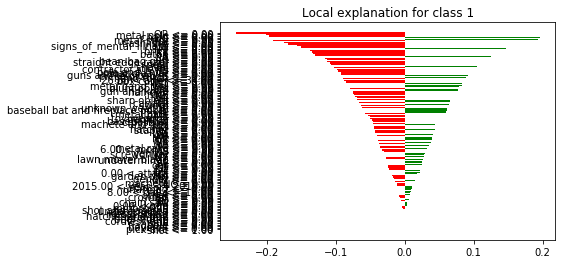

In [25]:
%matplotlib inline
exp.as_pyplot_figure()
plt.show()

In [27]:
features = sorted(list(zip(X.columns.tolist(), cart_clf.feature_importances_)), 
       key=lambda t:t[1], reverse=True)
for feature in features[:10]:
    print(feature)

('age', 0.22493395038266403)
('day', 0.1626058783659278)
('month', 0.11928124113218921)
('year', 0.04770578677516514)
('CA', 0.025197748436013658)
('signs_of_mental_illness', 0.022435734685181816)
('knife', 0.0215943595872303)
('FL', 0.0193818512180609)
('gun', 0.019003444563964095)
('other', 0.015730545612754568)


In [ ]:
explainer_cont = lime.lime_tabular.LimeTabularExplainer(X_test.as_matrix(), rf_clf.predict_proba, discretize_continuous=True)
exp_count = explainer_cont.explain_instance(X_test.iloc[0], rf_clf.predict_proba, num_features=X.shape[1], top_labels=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [ ]:
feature_scores = tabular_explainer.as_list()
feature_scores = sorted(feature_scores, key=lambda t:t[1], reverse=True) 
for elem in feature_scores:
    print(elem)
print([label_mapping[elem] for elem in tabular_explainer.top_labels])


In [ ]:
%matplotlib inline
tabular_explainer.as_pyplot_figure()
plt.show()